In [71]:
import numpy as np
import pandas  as pd
import seaborn as sea
import matplotlib.pyplot as plt
import glob
paths = sorted(glob.glob(f'datasets/Cryptocurrency Historical Prices/*.csv'))

In [75]:
dicionario = {'Csv':[],'Instancias':[]}
for i in paths:
    dicionario['Csv'].append(i.split('/')[2])
    dicionario['Instancias'].append(pd.read_csv(i).shape[0])

In [76]:
grupos = pd.DataFrame(dicionario)
grupos

,Csv,Instancias
0,coin_Aave.csv,275
1,coin_BinanceCoin.csv,1442
2,coin_Bitcoin.csv,2991
3,coin_Cardano.csv,1374
4,coin_ChainLink.csv,1385
5,coin_Cosmos.csv,845
6,coin_CryptocomCoin.csv,935
7,coin_Dogecoin.csv,2760
8,coin_EOS.csv,1466
9,coin_Ethereum.csv,2160


In [77]:
g1 = grupos.loc[grupos['Instancias']>2000]
g1

,Csv,Instancias
2,coin_Bitcoin.csv,2991
7,coin_Dogecoin.csv,2760
9,coin_Ethereum.csv,2160
11,coin_Litecoin.csv,2991
12,coin_Monero.csv,2602
13,coin_NEM.csv,2288
16,coin_Stellar.csv,2527
17,coin_Tether.csv,2318
22,coin_XRP.csv,2893


In [78]:
g2 = grupos.loc[(grupos['Instancias']>800) & (grupos['Instancias']<1000)] 
g2

,Csv,Instancias
5,coin_Cosmos.csv,845
6,coin_CryptocomCoin.csv,935
21,coin_WrappedBitcoin.csv,888


In [79]:
g3 = grupos.loc[(grupos['Instancias']<800)] 
g3

,Csv,Instancias
0,coin_Aave.csv,275
14,coin_Polkadot.csv,320
15,coin_Solana.csv,452
20,coin_Uniswap.csv,292


Farei a divisão de 3 grupos 
1. $>$ 2000 instancias
2. $>$ 800 & $<$ 1000 instancias
3. $<$ 800
> Para eviter viés

In [80]:
def Concats( paths , gn ):
    data = pd.DataFrame()
    for path in paths:
        for nomes in gn:
            if nomes in path:
                data =pd.concat([data, pd.read_csv(path)], ignore_index=True)
    return data
        

In [81]:
dataset = Concats(paths,g1['Csv'].values)
dataset.head(3)

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000,116.989998,0.0,1.298955e+09


In [82]:
dataset.head(3)

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000,116.989998,0.0,1.298955e+09


In [83]:
dataset.columns

Index(['SNo', 'Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close',
       'Volume', 'Marketcap'],
      dtype='object')

In [84]:
dataset.shape

(23530, 10)

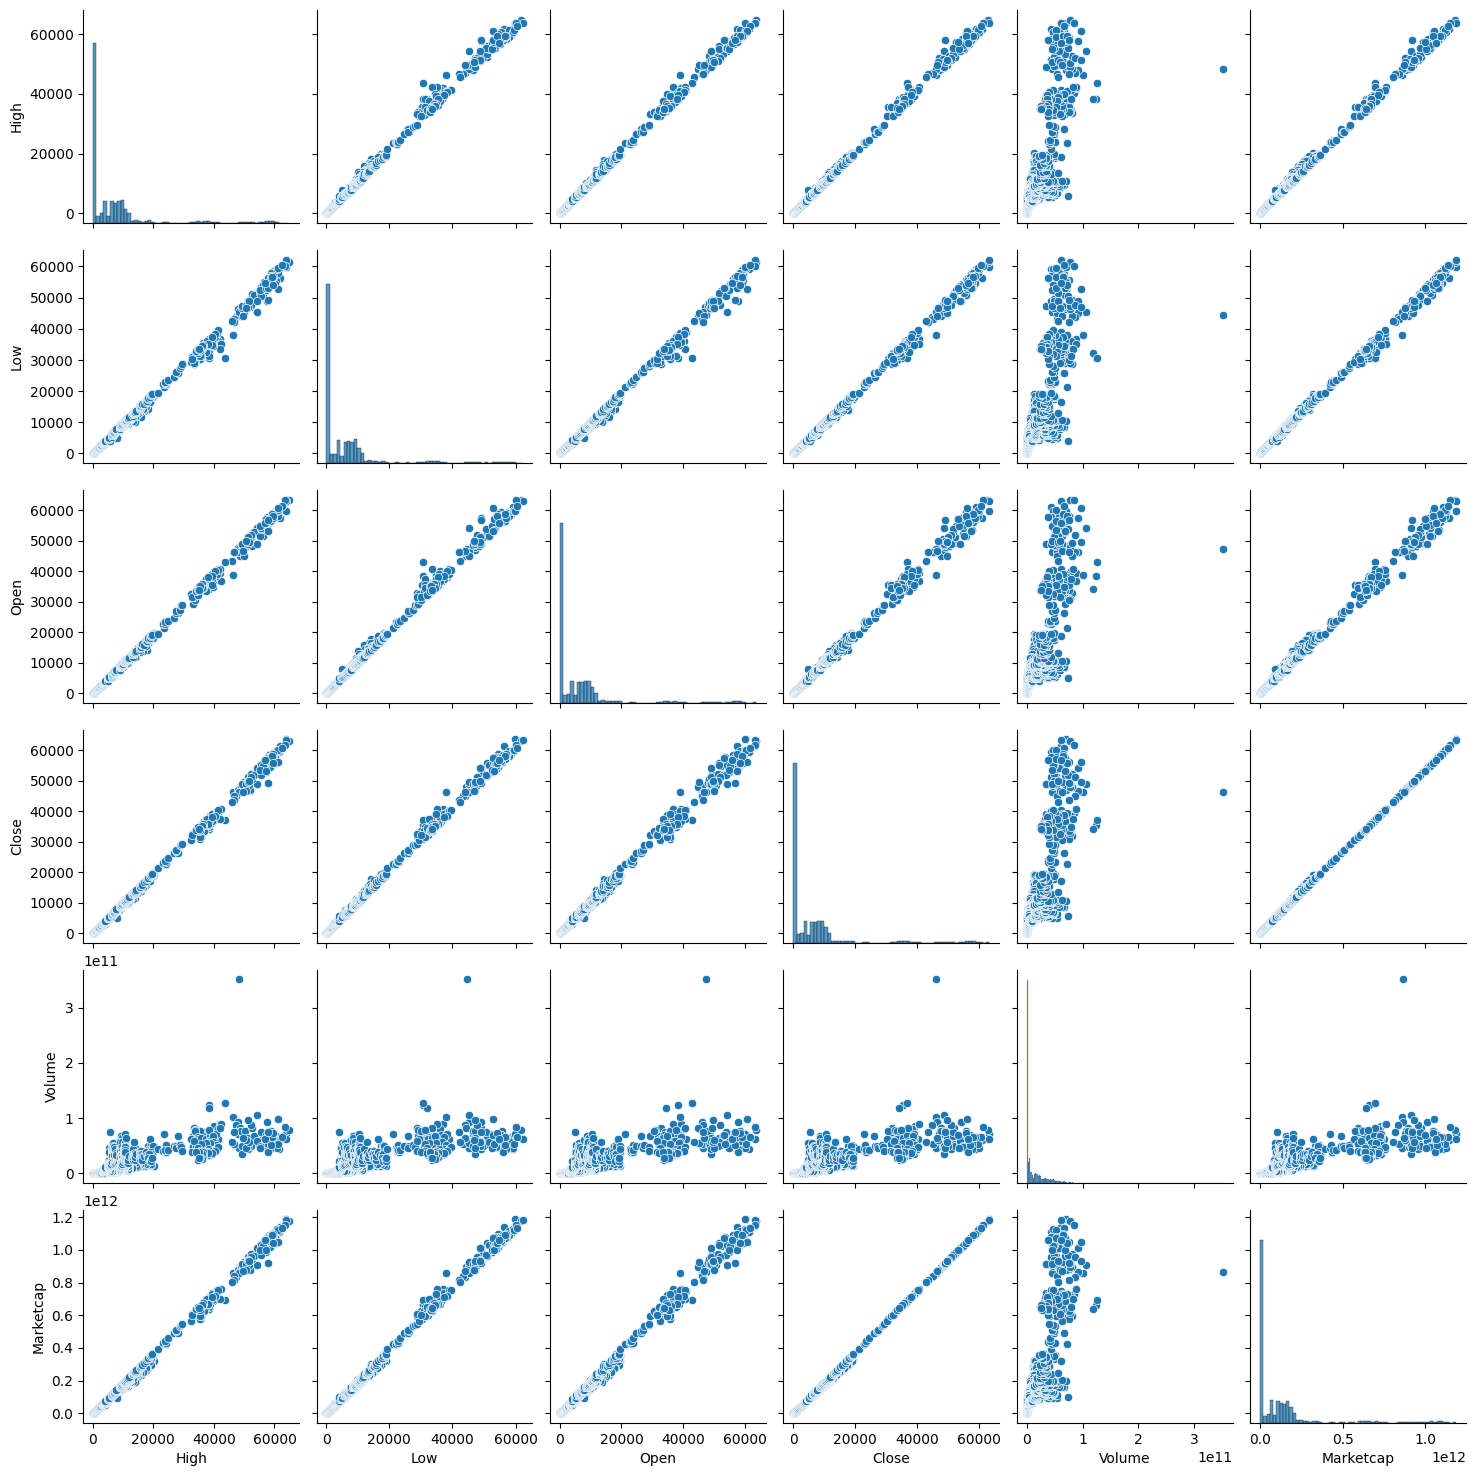

In [85]:
coluna = dataset['Symbol'].drop_duplicates()[0]
sea.pairplot(dataset.loc[dataset['Symbol']==coluna].select_dtypes(include='float'),hue_order='Marketcap')
plt.show()

&nbsp;

In [86]:
from sklearn.preprocessing   import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.base            import BaseEstimator,TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold,
    StratifiedShuffleSplit
    )
from sklearn.metrics import *
from sklearn.compose import TransformedTargetRegressor

In [87]:
from sklearn.linear_model import ElasticNet,Ridge,SGDRegressor
from sklearn.ensemble     import VotingRegressor,AdaBoostRegressor
from sklearn.svm          import LinearSVR

In [88]:
from yellowbrick.regressor import PredictionError

In [89]:
dataset = dataset.copy()

## Pré-processamento

Essa classes serão utlizada na pipeline para automatiza o processo de pre-processamento

In [90]:
class Padronizacao(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):  
        if ( type(self.columns) == list ):
            X[self.columns]   = StandardScaler().fit_transform(X[self.columns])
        else:
            X[[self.columns]] = StandardScaler().fit_transform(X[[self.columns]])
        return X

class Normalizacao(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):  
        X[self.columns] =  MinMaxScaler().fit_transform(X[self.columns].values.reshape(-1,1))
        return X

     
class Dummies(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        return pd.get_dummies(X,columns=self.columns,dtype=int)

In [91]:
class TransformancaoCasas(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list):
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X:pd.DataFrame,y=None):
        for column in self.columns:
            X[column] = (X[column])/1e+10
        return X

In [92]:
class RemovendoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list) -> None:
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop(columns=self.columns,axis=0)

In [93]:
x = dataset.drop(columns=['Symbol'],axis=0)
y = dataset['Symbol']
train ,test = None,None
for resultf  in StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42).split(x,y):
    train , test = resultf[0],resultf[1]

train  = dataset.iloc[train,:]
test   = dataset.iloc[test,:]

In [94]:
pipeline = Pipeline(
    steps=[
        ('Removing',RemovendoAtributos(['SNo','Name','Date'])),
        ('Padronizacao',Padronizacao(['High','Low','Open','Close','Volume'])),
        ('Normalizacao',TransformancaoCasas(['Marketcap'])),
        ('Dummies ',Dummies(['Symbol']))
        ]
)
train = pipeline.fit_transform(train)
test  = pipeline.fit_transform(test) 

<Axes: >

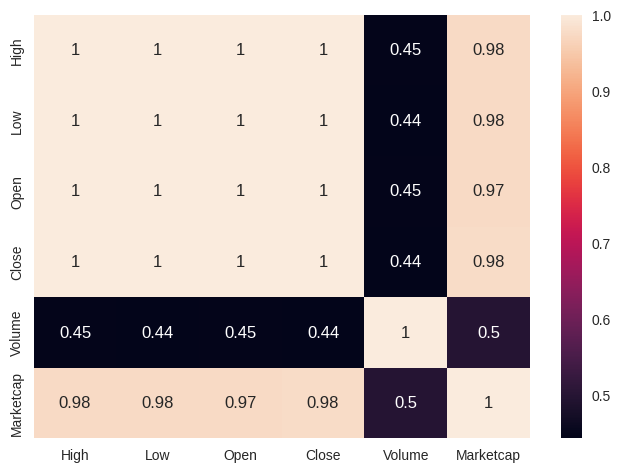

In [95]:
sea.heatmap(test.select_dtypes(exclude='int').corr(),annot=True)

<Axes: >

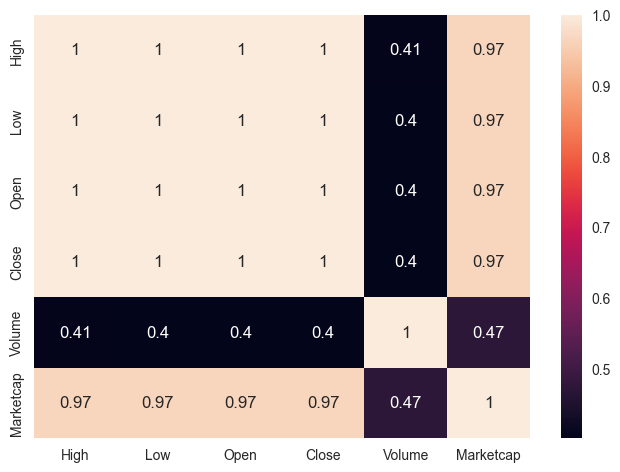

In [ ]:
sea.heatmap(train.select_dtypes(exclude='int').corr(),annot=True)

In [96]:
xtrain, xtest, ytrain, ytest = (
    train.drop(columns=['Marketcap'],axis=0).iloc[:,1:],
    test.drop(columns=['Marketcap'],axis=0).iloc[:,1:],
    train['Marketcap'],
    test['Marketcap']
)

In [97]:
pd.concat([ytest.describe(),ytrain.describe()],axis=1)

,Marketcap,Marketcap
count,4706.000000,18824.000000
mean,2.510081,2.126338
std,10.239231,8.361766
min,0.000025,0.000015
25%,0.014549,0.013550
50%,0.127786,0.126748
75%,0.821913,0.827087
max,118.636404,118.294549


&nbsp;

### Gradiente Descente

In [98]:

params = dict(
    alpha    = np.linspace(0.001,0.1,10),
)

gridGrad = GridSearchCV(SGDRegressor(penalty='l2'),param_grid=params,scoring='r2')
gridGrad.fit(xtrain,ytrain)

print('Melhor Estimador :',gridGrad.best_estimator_)
print('Score            :',gridGrad.best_score_)

Melhor Estimador : SGDRegressor(alpha=0.001)
Score            : 0.955340416402936


In [99]:
grad =  SGDRegressor(alpha=0.001)
grad.fit(xtrain,ytrain)

SGDRegressor(alpha=0.001)

In [100]:
predGrad = grad.predict(xtest)

In [111]:
print("Mean Absolute error..:",mean_absolute_error(ytest,predGrad))
print("Mean Squared error...:",np.sqrt(mean_squared_error(ytest,predGrad)))
print("r2 score.............:",r2_score(ytest,predGrad))

Mean Absolute error..: 0.9200004904191023
Mean Squared error...: 2.672576553496339
r2 score.............: 0.9318575185414422


&nbsp;

### Elastic Net

In [112]:
params = dict(
    alpha = np.linspace(0.1,1,10),
    l1_ratio = np.linspace(0.1,0.9,10)
)
gridNet = GridSearchCV( estimator=ElasticNet(), param_grid=params, scoring='r2') 
gridNet.fit(xtrain,ytrain)

Melhor Estimador : ElasticNet(alpha=0.1, l1_ratio=0.9)
Score            : 0.95114832146559


In [115]:
print('Melhor Estimador :',gridNet.best_estimator_)
print('Score            :',gridNet.best_score_)

Melhor Estimador : ElasticNet(alpha=0.1, l1_ratio=0.9)
Score            : 0.95114832146559


In [116]:
elastic = ElasticNet(alpha=0.1, l1_ratio=0.9)
elastic.fit(xtrain,ytrain)

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [117]:
predNet = grad.predict(xtest)

In [118]:
print("Mean Absolute error..:",mean_absolute_error(ytest,predNet))
print("Mean Squared error...:",np.sqrt(mean_squared_error(ytest,predNet)))
print("r2 score.............:",r2_score(ytest,predNet))

Mean Absolute error..: 0.9200004904191023
Mean Squared error...: 2.672576553496339
r2 score.............: 0.9318575185414422


&nbsp;

### LinearSvr

In [119]:
svr = LinearSVR(C=2.5)
svr.fit(xtrain,ytrain)

/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=2.5)

In [120]:
predSVR = svr.predict(xtest)

In [121]:
print("Mean Absolute error..:",mean_absolute_error(ytest,predSVR))
print("Mean Squared error...:",np.sqrt(mean_squared_error(ytest,predSVR)))
print("r2 score.............:",r2_score(ytest,predSVR))

Mean Absolute error..: 0.8198868307568127
Mean Squared error...: 2.8387603103273267
r2 score.............: 0.9231196970916092


### VotingRegressor

In [122]:
voting = VotingRegressor(
    estimators = [
        ('grad'    , SGDRegressor(alpha=0.001)),
        ('elastic' ,ElasticNet(alpha=0.1, l1_ratio=0.9)),
        ('svr'     ,LinearSVR(C=2.5))
    ],
    verbose=True
)
voting.fit(xtrain,ytrain)

[Voting] ..................... (1 of 3) Processing grad, total=   0.0s
[Voting] .................. (2 of 3) Processing elastic, total=   0.1s


/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[Voting] ...................... (3 of 3) Processing svr, total=   1.0s


/home/mateus/Documentos/venvGlobal/lib64/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingRegressor(estimators=[('grad', SGDRegressor(alpha=0.001)),
                            ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.9)),
                            ('svr', LinearSVR(C=2.5))],
                verbose=True)

In [123]:
predVoting = voting.predict(xtest)

In [124]:
print("Mean Absolute error..:",mean_absolute_error(ytest,predVoting))
print("Mean Squared error...:",np.sqrt(mean_squared_error(ytest,predVoting)))
print("r2 score.............:",r2_score(ytest,predVoting))

Mean Absolute error..: 0.834486867053826
Mean Squared error...: 2.725499875999414
r2 score.............: 0.929132033723953


Fazendo validadacao cruzada para o metodo ensemble acima

In [129]:
import tensorflow as tf 
import keras 

2024-04-27 18:30:54.645398: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 18:30:54.682797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 18:30:54.682839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 18:30:54.683849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 18:30:54.689461: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 18:30:54.689893: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [132]:
xtrain.shape

(18824, 13)

In [134]:
from functools import partial
def Model():
    Dense = partial(
        keras.layers.Dense,
        activation         = keras.activations.selu,
        kernel_initializer = keras.initializers.lecun_normal,   
    )
    model = keras.models.Sequential(
        layers=[
            Dense(30),
            Dense(15),
            Dense(7),
            Dense(4),
            Dense(2),
            keras.layers.Dense(1 , kernel_initializer = keras.initializers.lecun_normal),
        ]
    )
    model.compile(
        optimizer = keras.optimizers.RMSprop(),
        loss      = keras.losses.Huber()
    )

    return model

In [142]:
model = Model()

In [144]:
history = model.fit(xtrain, ytrain, batch_size=32, epochs=10)

Epoch 1/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0979
Epoch 2/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0960
Epoch 3/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0955
Epoch 4/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0945
Epoch 5/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0932
Epoch 6/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0919
Epoch 7/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0921
Epoch 8/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0915
Epoch 9/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0900
Epoch 10/10
589/589 [==============================] - 2s 3ms/step - loss: 0.0880


In [145]:
pred = model.predict(xtest)

148/148 [==============================] - 1s 2ms/step


In [146]:
print("Mean Absolute error..:",mean_absolute_error(ytest,pred))
print("Mean Squared error...:",np.sqrt(mean_squared_error(ytest,pred)))
print("r2 score.............:",r2_score(ytest,pred))

Mean Absolute error..: 0.6253914044505412
Mean Squared error...: 2.1753857055556445
r2 score.............: 0.9548528668723062
